# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from pmfgeneral8 import *
from bss_utils import *
from dsp_utils import *
from general_utils import *
from visualization_utils import * 

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Nonnegative_Antisparse_Copula'

# Source Generation and Mixing Scenario

In [12]:
N = 10000
NumberofSources = 10
NumberofMixtures = 20
S = generate_correlated_copula_sources(rho = 0.0, df = 4, n_sources = NumberofSources, 
                                       size_sources = N , decreasing_correlation = False)

print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.0064480629894


# Visualize Generated Sources and Mixtures

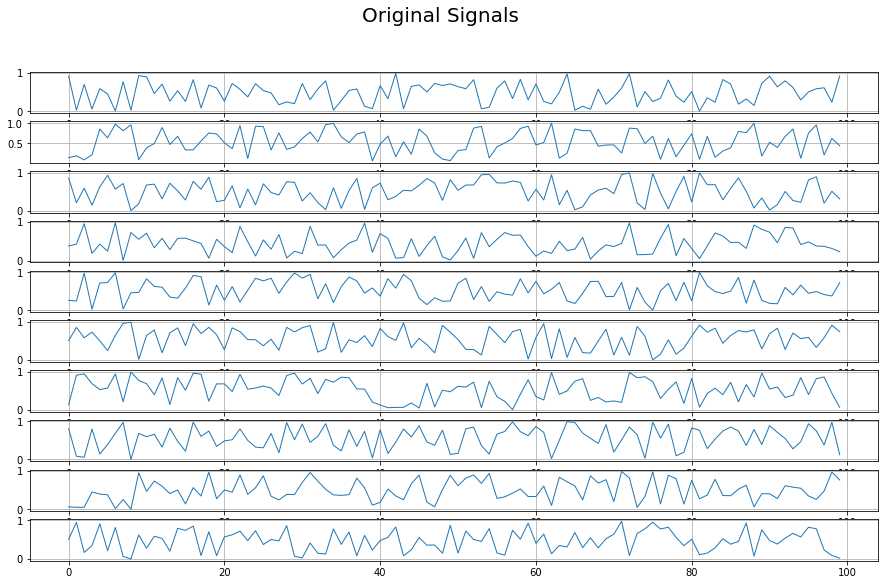

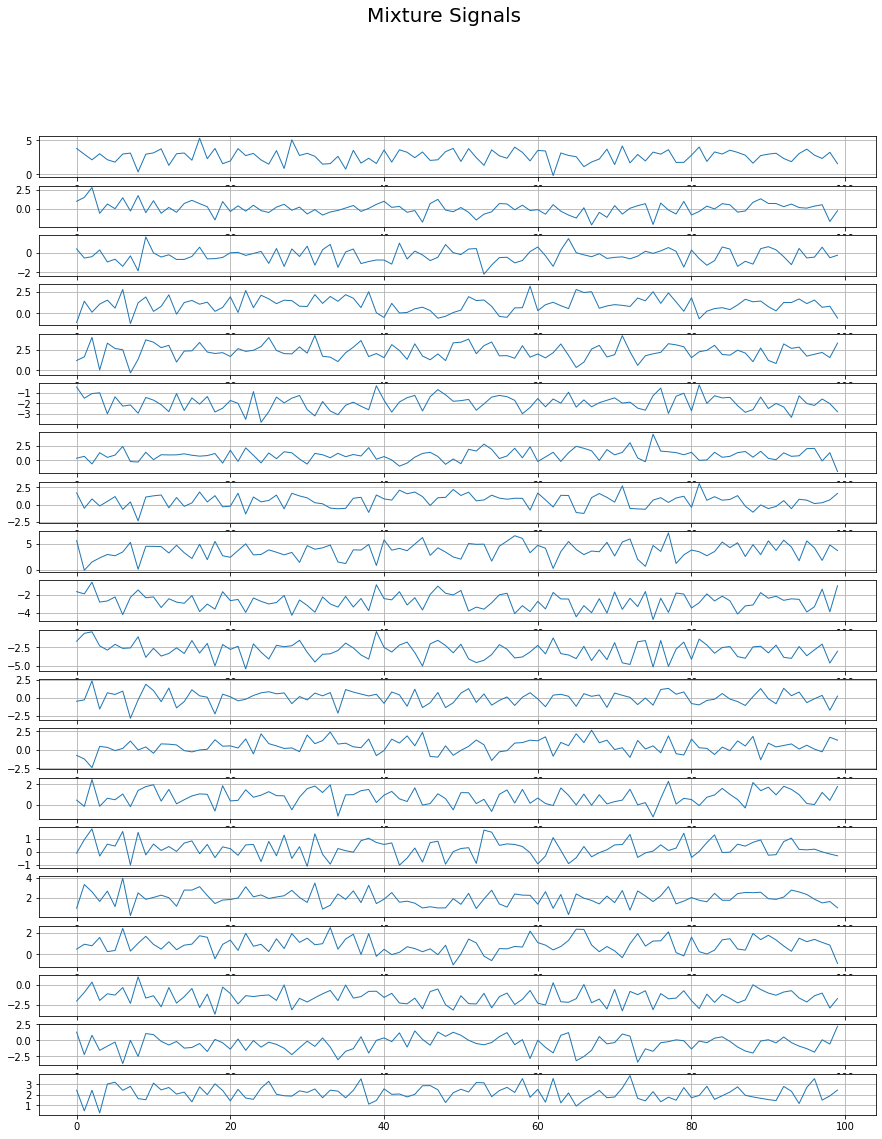

In [13]:
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X[:,0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

In [35]:
N = 2000
NumberofSources = 10
NumberofMixtures = 20
S = generate_correlated_copula_sources(rho = 0.0, df = 4, n_sources = NumberofSources, 
                                       size_sources = N , decreasing_correlation = False)

# print("The following is the correlation matrix of sources")
# display_matrix(np.corrcoef(S))

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
# print("The following is the mixture matrix A")
# display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

Input SNR is : 29.972125311101536


In [36]:
#---------------------------PMF---------------------------------
NumIterations=10000
R = NumberofSources
pmf2=pmf(X,R)   
pmf2.BoundMax=np.array([np.ones(R)])
pmf2.BoundMin=np.array([np.zeros(R)])
pmf2.SparseList=np.array([],dtype=object)
pmf2.SetGroundTruth(S.T)
pmf2.SetGroundTruthW(A)
pmf2.MaxIterations=1
pmf2.algorithm_iterations=1000
pmf2.step_size_rule='const'
pmf2.checklocalstationary=0
pmf2.detwindow=100
pmf2.algorithm_iterations=NumIterations
pmf2.Lt=30

In [37]:
M = NumberofMixtures
a = np.random.random(size=(M, R))
q, _ = np.linalg.qr(a)
q.shape

(20, 10)

In [38]:
pmf2.W = q
pmf2.noisy_general(checklocalstationary=0,verbose=1,HProjectionPeriod=1,tau=1e-10,nlamda=15, p=2)

0
5000


In [39]:
# Wf = model.W
Y = pmf2.H.T
Y_ = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr(S, Y_)))

SINR = 10*np.log10(CalculateSINR(Y_, S)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [26.19844742 25.62306542 26.35613594 30.76684336  3.64374112 22.06917096
 28.33561761 29.32213472 25.39661422 25.49659901]

Overall SINR : 26.553872028597976


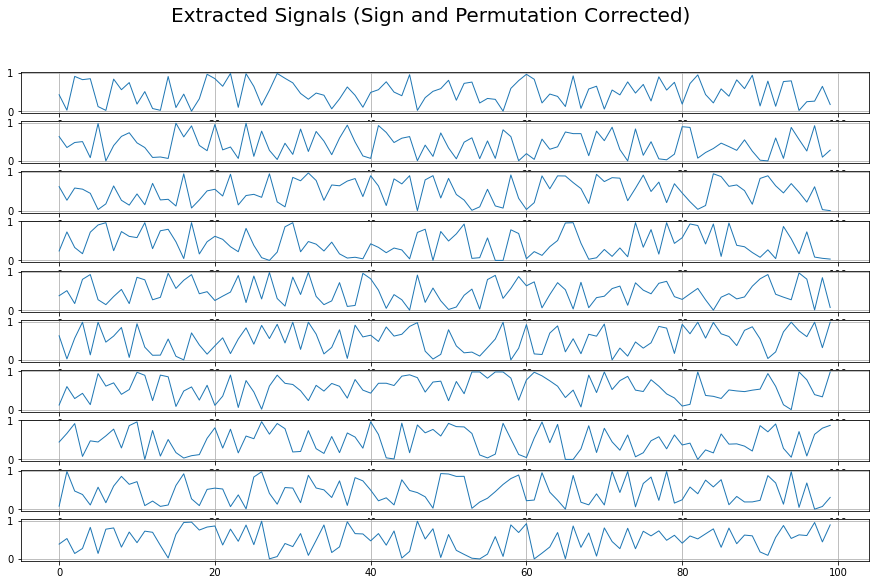

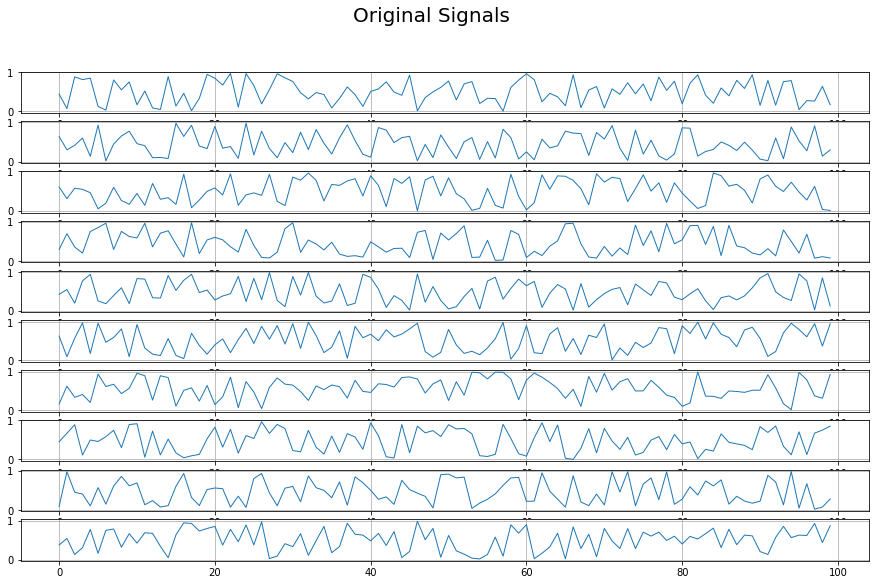

In [24]:
subplot_1D_signals(Y_[:,0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
s_dim = S.shape[0]
x_dim = X.shape[0]
debug_iteration_point = 200
model = PMF(s_dim = s_dim, x_dim = x_dim,
                set_ground_truth = True, Sgt = S, Agt = A)

# Run LDMI Algorithm on Mixture Signals

In [6]:
model.fit_batch_nnantisparse(X, Lt = 50, lambda_ = 10, tau = 1e-8, 
                             plot_in_jupyter = True)

 15%|█▌        | 1500/10000 [00:23<02:11, 64.67it/s] 

KeyboardInterrupt

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x2ba0d841cd30>
Traceback (most recent call last):
  File "/kuacc/users/bbozkurt15/.conda/envs/wsm/lib/python3.8/site-packages/matplotlib/transforms.py", line 222, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


Error in callback <function flush_figures at 0x2ba0b4b49dc0> (for post_execute):


KeyboardInterrupt: 

# Calculate Resulting Component SNRs and Overall SINR

In [8]:
# Wf = model.W
Y = model.S_
Y_ = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINR = 10*np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [6.04327993 6.07456992 5.96782612 5.99678433 6.04779054]

Overall SINR : 36.99129104750812


# Vizualize Extracted Signals Compared to Original Sources

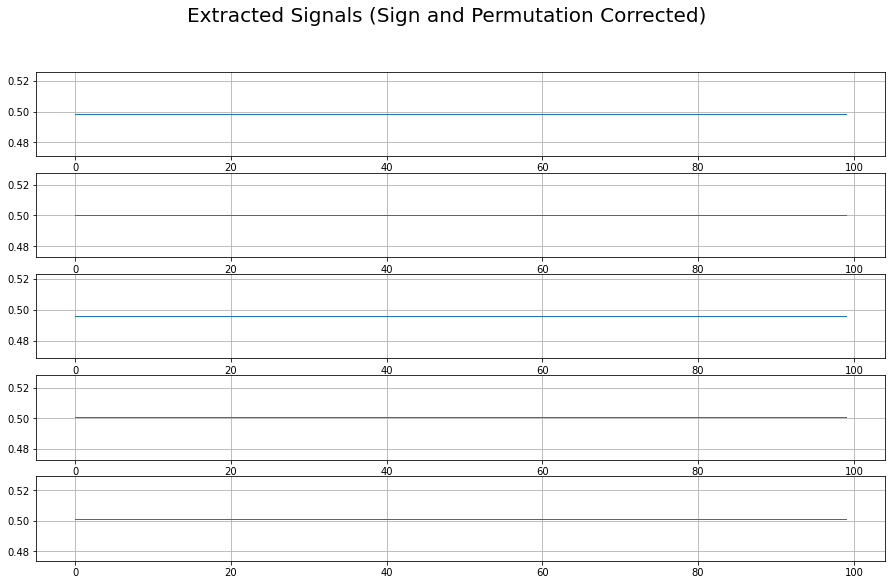

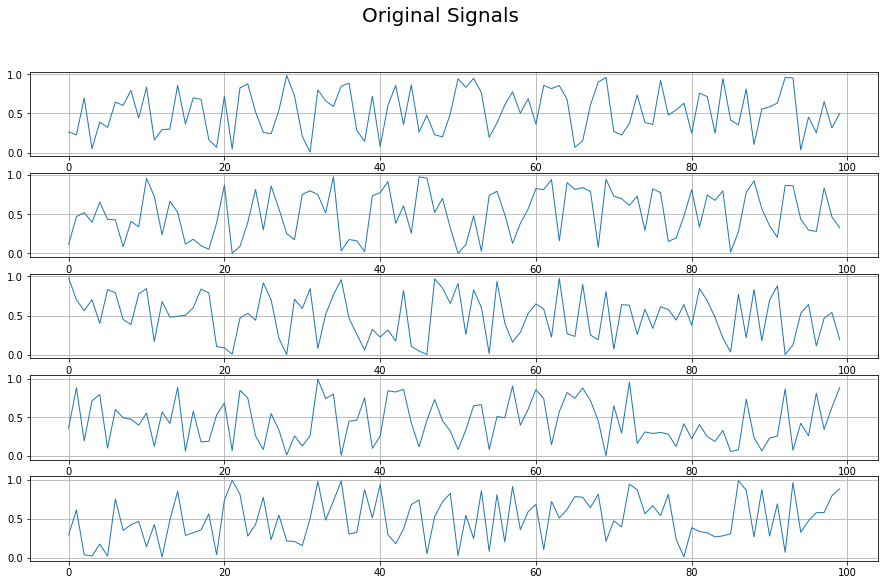

In [9]:
subplot_1D_signals(Y_[:,0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)

In [ ]:
S.shape

In [ ]:
A.shape

In [ ]:
Agt = np.random.randn(10, 5)
H = np.random.randn(10000, 5)
W = np.random.randn(10, 5)
Y = Agt @ H.T
Lt = 5

In [ ]:
(Lt*np.linalg.norm(np.transpose(W)@W, 2))

In [ ]:
(np.dot(np.transpose(W),(np.dot(W,np.transpose(H)) - Y)))